In [4]:
import random

import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#学習データ
x_train = np.load('/workdir/tmp/data/x_train.npy')
t_train = np.load('/workdir/tmp/data/t_train.npy')

#テストデータ
x_test = np.load('/workdir/tmp/data/x_test.npy')

class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i])))
        self.t_train = t_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(t_train[idx], dtype=torch.long)

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        data = x_test.astype('float32')
        self.x_test = []
        for i in range(data.shape[0]):
            self.x_test.append(Image.fromarray(np.uint8(data[i])))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.transform(self.x_test[idx])

trainval_data = train_dataset(x_train, t_train)
test_data = test_dataset(x_test)

In [2]:
val_size = 3000
train_data, valid_data = torch.utils.data.random_split(trainval_data, [len(trainval_data) - val_size, val_size])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),])# WRITE ME
valid_transform = transforms.Compose([transforms.ToTensor()])# WRITE ME
test_transform = transforms.Compose([transforms.ToTensor()])# WRITE ME

batch_size = 128

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [23]:
import math
from torch import nn, optim
import torch.nn.functional as nnf
from einops.layers.torch import Rearrange
from einops import rearrange

def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)


def random_indexes(size):
    """
    パッチをランダムに並べ替えるためのindexを生成する関数．

    Argument
    --------
    size : int
        入力されるパッチの数（系列長Nと同じ値）．
    """
    forward_indexes = np.arange(size)  # 0からsizeまでを並べた配列を作成
    np.random.shuffle(forward_indexes)  # 生成した配列をシャッフルすることで，パッチの順番をランダムに決定
    backward_indexes = np.argsort(forward_indexes)  # 並べ替えたパッチをもとの順番に戻すためのidx

    return forward_indexes, backward_indexes


def take_indexes(sequences, indexes):
    """
    パッチを並べ替えるための関数．

    Argument
    --------
    sequences : torch.Tensor
        入力画像をパッチ分割したデータ．(B, N, dim)の形状をしている．
    indexes : np.ndarray
        並べ替えるために利用するindex．
        random_indexesで生成したforward_indexesかbackward_indexesが入ることが想定されている．
    """
    return torch.gather(sequences, dim=1, index=indexes.unsqueeze(2).repeat(1, 1, sequences.shape[-1]))


class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．埋め込み次元数と一致する．
        heads : int
            ヘッドの数．
        dim_head : int
            各ヘッドのデータの次元数．
        dropout : float
            Dropoutの確率(default=0.)．
        """
        super().__init__()

        self.dim = dim
        self.dim_head = dim_head
        inner_dim = dim_head * heads  # ヘッドに分割する前のQ, K, Vの次元数．self.dimと異なっても良い．
        project_out = not (heads == 1 and dim_head == dim)  # headsが1，dim_headがdimと等しければ通常のSelf-Attention

        self.heads = heads
        self.scale = math.sqrt(dim_head)  # ソフトマックス関数を適用する前のスケーリング係数(dim_k)

        self.attend = nn.Softmax(dim=-1)  # アテンションスコアの算出に利用するソフトマックス関数
        self.dropout = nn.Dropout(dropout)

        # Q, K, Vに変換するための全結合層
        self.to_q = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_k = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_v = nn.Linear(in_features=dim, out_features=inner_dim)

        # dim != inner_dimなら線形層を入れる，そうでなければそのまま出力
        self.to_out = nn.Sequential(
            nn.Linear(in_features=inner_dim, out_features=dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        """
        B: バッチサイズ
        N: 系列長
        D: データの次元数(dim)
        """
        B, N, D = x.size()

        # 入力データをQ, K, Vに変換する
        # (B, N, dim) -> (B, N, inner_dim)
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        # Q, K, Vをヘッドに分割する
        # (B, N, inner_dim) -> (B, heads, N, dim_head)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)

        # QK^T / sqrt(d_k)を計算する
        # (B, heads, N, dim_head) x (B, heads, dim_head, N) -> (B, heads, N, N)
        dots = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        # ソフトマックス関数でスコアを算出し，Dropoutをする
        attn = self.attend(dots)
        attn = self.dropout(attn)

        # softmax(QK^T / sqrt(d_k))Vを計算する
        # (B, heads, N, N) x (B, heads, N, dim_head) -> (B, heads, N, dim_head)
        out = torch.matmul(attn ,v)

        # もとの形に戻す
        # (B, heads, N, dim_head) -> (B, N, dim)
        out = rearrange(out, "b h n d -> b n (h d)", h=self.heads, d=self.dim_head)

        # 次元が違っていればもとに戻して出力
        # 表現の可視化のためにattention mapも返すようにしておく
        return self.to_out(out), attn


class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．
        hidden_dim : int
            隠れ層の次元．
        dropout : float
            各全結合層の後のDropoutの確率(default=0.)．
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=dim, out_features=hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_dim, out_features=dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        (B, D) -> (B, D)
        B: バッチサイズ
        D: 次元数
        """
        return self.net(x)


class Block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout):
        """
        TransformerのEncoder Blockの実装．

        Arguments
        ---------
        dim : int
            埋め込みされた次元数．PatchEmbedのembed_dimと同じ値．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            Droptou層の確率p．
        """
        super().__init__()

        self.attn_ln = nn.LayerNorm(dim)  # Attention前のLayerNorm
        self.attn = Attention(dim, heads, dim_head, dropout)
        self.ffn_ln = nn.LayerNorm(dim)  # FFN前のLayerNorm
        self.ffn = FFN(dim, mlp_dim, dropout)

    def forward(self, x, return_attn=False):
        """
        x: (B, N, dim)
        B: バッチサイズ
        N: 系列長
        dim: 埋め込み次元
        """
        y, attn = self.attn(self.attn_ln(x))
        if return_attn:  # attention mapを返す（attention mapの可視化に利用）
            return attn
        x = y + x
        out = self.ffn(self.ffn_ln(x)) + x

        return out


class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        """
        入力画像をパッチごとに埋め込むための層．

        Arguments
        ---------
        image_size : Tuple[int]
            入力画像のサイズ．
        patch_size : Tuple[int]
            各パッチのサイズ．
        in_channels : int
            入力画像のチャネル数．
        embed_dim : int
            埋め込み後の次元数．
        """
        super().__init__()

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, "パッチサイズは，入力画像のサイズを割り切れる必要があります．"

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # パッチの数
        patch_dim = in_channels * patch_height * patch_width  # 各パッチを平坦化したときの次元数

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),  # 画像をパッチに分割して平坦化
            nn.Linear(in_features=patch_dim, out_features=embed_dim),  # 埋め込みを行う
        )

    def forward(self, x):
        """
        B: バッチサイズ
        C: 入力画像のチャネル数
        H: 入力画像の高さ
        W: 入力画像の幅
        """
        return self.to_patch_embedding(x)  # (B, C, H, W) -> (B, num_patches, embed_dim)


class PatchShuffle(nn.Module):
    def __init__(self, ratio):
        # ratio: Encoderに入力しないパッチの割合
        super().__init__()
        self.ratio = ratio

    def forward(self, patches):
        """
        B: バッチサイズ
        N: 系列長（＝パッチの数）
        dim: 次元数（＝埋め込みの次元数）
        """
        B, N, dim = patches.shape
        remain_N = int(N * (1 - self.ratio))  # Encoderに入力するパッチの数

        indexes = [random_indexes(N) for _ in range(B)]  # バッチごとに異なる順番のindexを作る
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # バッチを並べ替えるときのidx (B, N)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # 並べ替えたパッチをもとの順番に戻すためのidx  (B, N)

        patches = take_indexes(patches, forward_indexes)  # パッチを並べ替える
        patches = patches[:, :remain_N, :]  # Encoderに入力するパッチを抽出

        return patches, forward_indexes, backward_indexes


class MAE_Encoder(torch.nn.Module):
    def __init__(self, image_size=[32, 32], patch_size=[2, 2], emb_dim=192, num_layer=12,
                 heads=3, dim_head=64, mlp_dim=192, mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Encoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.cls_token = torch.nn.Parameter(torch.randn(1, 1, emb_dim))  # class tokenの初期化
        self.pos_embedding = torch.nn.Parameter(torch.randn(1, num_patches, emb_dim))  # positional embedding（学習可能にしている）
        self.shuffle = PatchShuffle(mask_ratio)

        # 入力画像をパッチに分割する
        self.patchify = PatchEmbedding(image_size, patch_size, 3, emb_dim)

        # Encoder（Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        self.layer_norm = nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, img):
        # 1. 入力画像をパッチに分割して，positional embeddingする
        patches = self.patchify(img)
        patches = patches + self.pos_embedding

        # 2. 分割したパッチをランダムに並べ替えて，必要なパッチのみ得る
        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        # class tokenを結合
        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)

        # 3. Encoderで入力データを処理する
        features = self.layer_norm(self.transformer(patches))

        return features, backward_indexes


class MAE_Decoder(nn.Module):
    def __init__(self, image_size=[32, 32], patch_size=[2, 2], emb_dim=192, num_layer=4,
                 heads=3, dim_head=64, mlp_dim=192, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Decoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.mask_token = torch.nn.Parameter(torch.rand(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.rand(1, num_patches+1, emb_dim))

        # Decoder(Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        # 埋め込みされた表現から画像を復元するためのhead
        self.head = torch.nn.Linear(emb_dim, 3 * patch_height * patch_width)
        # (B, N, dim)から(B, C, H, W)にreshapeするためのインスタンス
        self.patch2img = Rearrange("b (h w) (c p1 p2) -> b c (h p1) (w p2)", p1=patch_height, p2=patch_width, h=img_height // patch_height)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.mask_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, features, backward_indexes):
        # 系列長
        T = features.shape[1]

        # class tokenがある分backward_indexesの最初に0を追加する
        # .toはデバイスの変更でよく利用するが，tensorを渡すことでdtypeを変えることができる
        backward_indexes = torch.cat([torch.zeros(backward_indexes.shape[0], 1).to(backward_indexes), backward_indexes+1], dim=1)

        # 1. mask_tokenを結合して並べ替える．
        # (B, N*(1-mask_ratio)+1, dim) -> (B, N+1, dim)
        features = torch.cat([features, self.mask_token.repeat(features.shape[0], backward_indexes.shape[1] - features.shape[1], 1)], dim=1)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = self.transformer(features)

        # class tokenを除去する
        # (B, N+1, dim) -> (B, N, dim)
        features = features[:, 1:, :]

        # 2. 画像を再構成する．
        # (B, N, dim) -> (B, N, 3 * patch_height * patch_width)
        patches = self.head(features)

        # MAEではマスクした部分でのみ損失関数を計算するため，maskも一緒に返す
        mask = torch.zeros_like(patches)
        mask[:, T-1:] = 1  # cls tokenを含めていた分ずらしている
        mask = take_indexes(mask, backward_indexes[:, 1:] - 1)
        print(mask.shape)

        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask


class MAE_ViT(torch.nn.Module):
    def __init__(self, image_size=[32, 32], patch_size=[2, 2], emb_dim=192,
                 enc_layers=12, enc_heads=3, enc_dim_head=64, enc_mlp_dim=768,
                 dec_layers=4, dec_heads=3, dec_dim_head=64, dec_mlp_dim=768,
                 mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------
        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        {enc/dec}_layers : int
            Encoder / Decoderに含まれるBlockの数．
        {enc/dec}_heads : int
            Encoder / DecoderのMulti-Head Attentionのヘッドの数．
        {enc/dec}_dim_head : int
            Encoder / DecoderのMulti-Head Attentionの各ヘッドの次元数．
        {enc/dec}_mlp_dim : int
            Encoder / DecoderのFeed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, enc_layers,
                                   enc_heads, enc_dim_head, enc_mlp_dim, mask_ratio, dropout)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, dec_layers,
                                   dec_heads, dec_dim_head, dec_mlp_dim, dropout)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        rec_img, mask = self.decoder(features, backward_indexes)
        return rec_img, mask

    def get_last_selfattention(self, x):
        patches = self.encoder.patchify(x)
        patches = patches + self.encoder.pos_embedding

        patches = torch.cat([self.encoder.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.encoder.transformer):
            if i < len(self.encoder.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)


# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# ハイパーパラメータの設定
config = {
    "image_size": [32, 32],
    "patch_size": [2, 2],
    "emb_dim": 192,
    "enc_layers": 12,
    "enc_heads": 3,
    "enc_dim_head": 64,
    "enc_mlp_dim": 192,
    "dec_layers": 4,
    "dec_heads": 3,
    "dec_dim_head": 64,
    "dec_mlp_dim": 192,
    "mask_ratio": 0.75,
    "dropout": 0.
}


device = "cuda" if torch.cuda.is_available() else "cpu"
model = MAE_ViT(**config).to(device)

epochs = 100
lr = 0.003
warmup_length = epochs // 10
batch_size = 512
step_count = 0
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)
scheduler = CosineScheduler(epochs, lr, warmup_length)

In [24]:
model.load_state_dict(torch.load("/workdir/tmp/MYmodel/MAE_pretrain_params.pth"))

<All keys matched successfully>

In [25]:
model.eval()
x, _ = next(iter(dataloader_valid))
with torch.no_grad():
    rec_img, mask = model(x.to(device))
    
x, rec_img, mask = x.detach().cpu(), rec_img.detach().cpu(), mask.detach().cpu()

torch.Size([128, 256, 12])


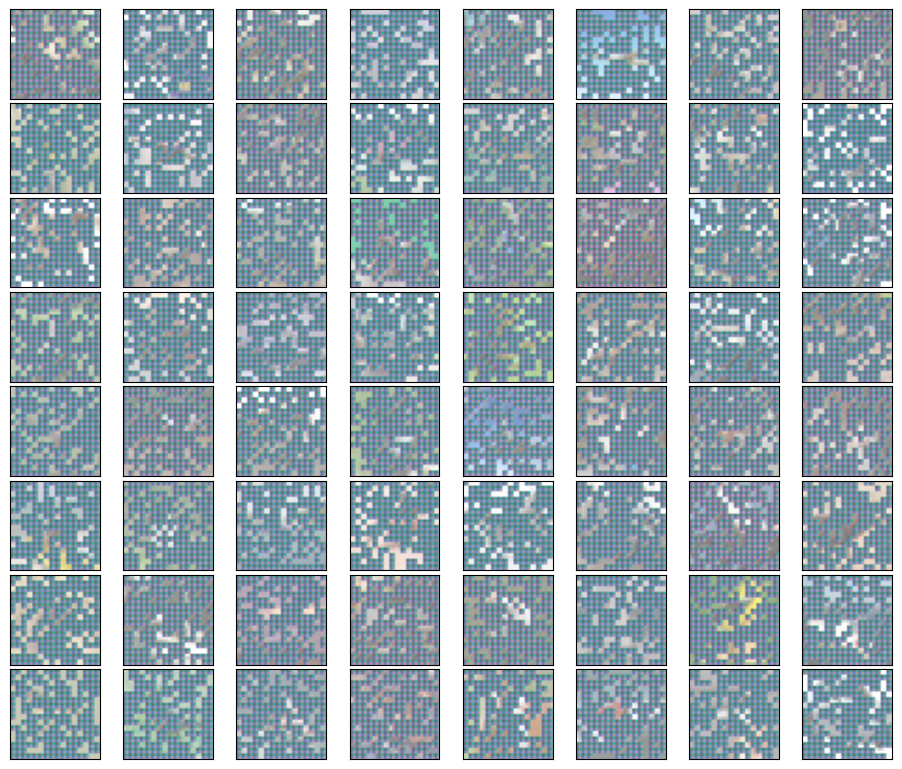

In [15]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# MAEの出力そのままを可視化する場合
# imgs = rec_img

# マスクしていた部分は元の画像を用いる
imgs = rec_img * mask + x * (1 - mask)
imgs = (imgs.data + 1) / 2  # 標準化した状態から0-1に戻す
i = 0
for img in imgs[:64]:
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

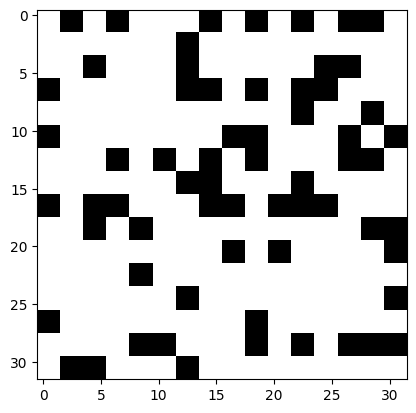

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(mask[0].permute(1,2,0))

In [20]:
import torchvision.utils as vutils

In [21]:
imgss = vutils.make_grid(rec_img[:64], normalize=True)

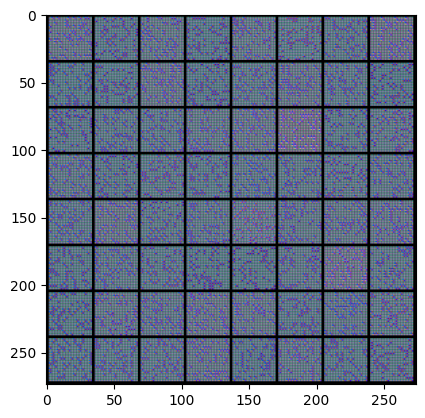

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(imgss.permute(1,2,0))

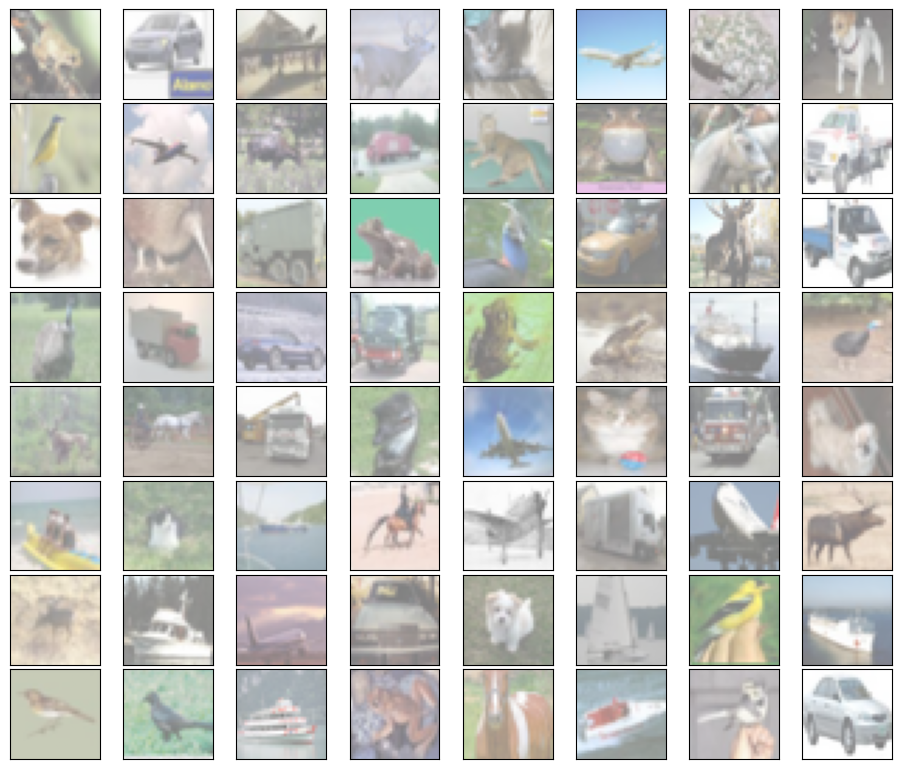

In [10]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
imgs = (x.data + 1) / 2
for img in imgs[:64]:
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1